In [1]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid
# Check which device is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {}'.format(device))

Using cuda


To load our dataset, we will subclass [`torch.utils.data.Dataloader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset).

In [2]:



import os
import glob

import pandas as pd
from torch.utils.data import Dataset
from PIL import Image


class Dataset(Dataset):
    def __init__(self, data_dir, transform=None):
        '''Custom dataset class for loading images and labels from a directory.

            Args:
                data_dir (str): Directory path containing the images and labels.
                transform (callable, optional): Optional transform to be applied to the images. Defaults to None.

            Attributes:
                image_paths (list): List of paths to the image files.
                labels (numpy.ndarray): Array of labels corresponding to the images.
                transform (callable): Transform to be applied to the images.
                n (int): Number of samples in the dataset.

            Methods:
                __len__(): Returns the number of samples in the dataset.
                __getitem__(idx): Retrieves the image and its corresponding label at the given index.
        '''
        if(os.path.exists(os.path.join(data_dir + "\\buildings"))):
            folders = ['buildings', 'forest',
                       'glacier', 'mountain', 'sea', 'street']
            self.image_paths = []
            for folder in folders:
                updated_dir = os.path.join(data_dir + f'\\{folder}')
                self.image_paths += glob.glob(
                    os.path.join(updated_dir, '*.jpg'))
        else:
            self.image_paths = glob.glob(
                os.path.join(data_dir, '*.jpg'))

        self.image_paths.sort()
        labels_path = os.path.join(data_dir, "labels.csv")
        self.labels = pd.read_csv(labels_path, header=None).to_numpy()[
            :, 1] if os.path.isfile(labels_path) else None
        self.transform = transform
        self.n = len(self.image_paths)

    def __len__(self):
        ''' Returns the number of samples in the dataset.

            Returns:
                int: Number of samples in the dataset.
        '''
        return self.n

    def __getitem__(self, idx):
        ''' Retrieves the image and its corresponding label at the given index.

            Args:
                idx (int): Index of the sample to retrieve.

            Returns:
                tuple: Tuple containing the transformed image and its label.
        '''
        img_path = self.image_paths[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)

        if self.labels is None:
            if img_path.split('\\')[-2] == 'buildings':
                label = 0
            elif img_path.split('\\')[-2] == 'forest':
                label = 1
            elif img_path.split('\\')[-2] == 'glacier':
                label = 2
            elif img_path.split('\\')[-2] == 'mountain':
                label = 3
            elif img_path.split('\\')[-2] == 'sea':
                label = 4
            else:
                label = 5
        else:
            label = self.labels[idx]
        return img_transformed, label

In [3]:
test_data_dir = 'data/intel_image_classification_dataset/seg_test/seg_test/'
train_data_dir ='data/intel_image_classification_dataset/seg_train/seg_train/'
eval_transforms = transforms.Compose([
    transforms.Resize(size=(150,150)),
    transforms.ToTensor()
])

In [4]:
train_dataset = ImageFolder(train_data_dir,transforms.Compose([
    transforms.Resize((150,150)),transforms.ToTensor()
]))

test_dataset = ImageFolder(test_data_dir,transforms.Compose([
    transforms.Resize((150,150)),transforms.ToTensor()
]))




In [5]:
image,label = train_dataset[0]

print(image.shape,label)

torch.Size([3, 150, 150]) 0


In [6]:
print("Follwing classes are there : \n",train_dataset.classes)

Follwing classes are there : 
 ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


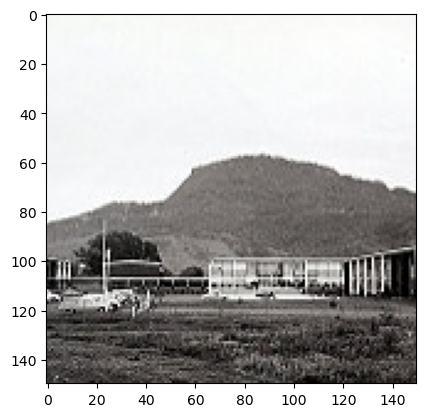

In [7]:
def display_image(image,label):
     plt.imshow(image.permute(1,2,0))

display_image(*train_dataset[0])

In [8]:
#Hyper parameter
BATCH_SIZE = 128
test_size = 2000
train_size = len(train_dataset) - test_size

In [9]:
#splitting traina nd valid data
train_data,valid_data = random_split(train_dataset,[train_size,test_size])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(valid_data)}")

Length of Train Data : 12034
Length of Validation Data : 2000


In [10]:
train_loader = DataLoader(train_data,BATCH_SIZE,shuffle=True,num_workers = 4, pin_memory = True)
valid_loader = DataLoader(valid_data,BATCH_SIZE,num_workers = 4, pin_memory = True)
test_loader = DataLoader(test_dataset, batch_size=4, pin_memory = True )

In [11]:

print(f"Length of Train Data : {len(train_dataset)}")
print(f"Length of Validation Data : {len(test_loader)}")

Length of Train Data : 14034
Length of Validation Data : 750


In [12]:
def show_batch_images(dataloader):
    for images,labels in dataloader:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break

In [13]:
show_batch_images(train_loader)

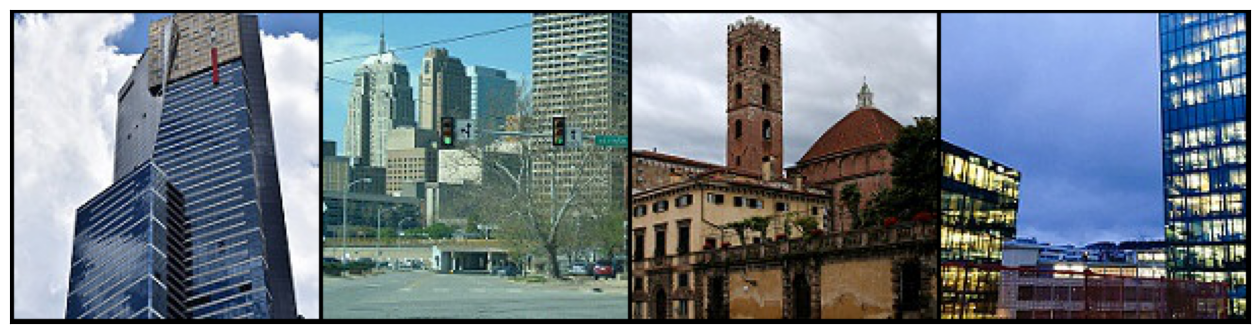

In [40]:
show_batch_images(test_loader)

Let's look at some of the training images:

Now we will define our CNN model with four convolutional layers and two fully-connected layers. After each of our convolutional layers, we apply batch normalisation and max pooling. Note that we are using a mix of the subclassing and sequential approaches this time.

In [41]:
import torch.nn as nn

class DepthwiseSeparableConv2d(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(DepthwiseSeparableConv2d, self).__init__()
        self.depthwise_conv = torch.nn.Conv2d(in_channels, in_channels, kernel_size, stride, padding, groups=in_channels)
        self.pointwise_conv = torch.nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        x = self.depthwise_conv(x)
        x = self.pointwise_conv(x)
        return x


class Model(torch.nn.Module):
    def __init__(self, num_classes=6):
        super(Model, self).__init__()

        self.features = torch.nn.Sequential(
            
            torch.nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(inplace=True),

            DepthwiseSeparableConv2d(32, 64),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(inplace=True),

            DepthwiseSeparableConv2d(64, 128, stride=2),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(inplace=True),

            DepthwiseSeparableConv2d(128, 128),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(inplace=True),

            DepthwiseSeparableConv2d(128, 256, stride=2),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(inplace=True),

            DepthwiseSeparableConv2d(256, 256),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(inplace=True),

            DepthwiseSeparableConv2d(256, 512, stride=2),
            torch.nn.BatchNorm2d(512),
            torch.nn.ReLU(inplace=True),

            DepthwiseSeparableConv2d(512, 512),
            torch.nn.BatchNorm2d(512),
            torch.nn.ReLU(inplace=True),

            DepthwiseSeparableConv2d(512, 512),
            torch.nn.BatchNorm2d(512),
            torch.nn.ReLU(inplace=True),

            DepthwiseSeparableConv2d(512, 512),
            torch.nn.BatchNorm2d(512),
            torch.nn.ReLU(inplace=True),

            DepthwiseSeparableConv2d(512, 512),
            torch.nn.BatchNorm2d(512),
            torch.nn.ReLU(inplace=True),

            DepthwiseSeparableConv2d(512, 1024, stride=2),
            torch.nn.BatchNorm2d(1024),
            torch.nn.ReLU(inplace=True),

            DepthwiseSeparableConv2d(1024, 1024),
            torch.nn.BatchNorm2d(1024),
            torch.nn.ReLU(inplace=True),

            torch.nn.AdaptiveAvgPool2d((1, 1)),
        )

        self.classifier = torch.nn.Sequential(
            torch.nn.Dropout(p=0.2),
            torch.nn.Linear(1024, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

The model will now be instantiated

In [42]:
# Create an object from the model
model = Model().to(device)

# Set loss function and optimizer
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

We will train the model for 10 epochs. After each epoch, we evaluate on the validation set.

In [43]:
train_losses, val_losses = [], []
train_accs, val_accs = [], []
# Train for 10 epochs
for epoch in range(10):
    ### Training
    # Track epoch loss and accuracy
    epoch_loss, epoch_accuracy = 0, 0
    # Switch model to training (affects batch norm and dropout)
    model.train()
    # Iterate through batches
    for i, (data, label) in enumerate(train_loader):
        # Reset gradients
        optimizer.zero_grad()
        # Move data to the used device
        data = data.to(device)
        label = label.to(device)
        # Forward pass
        output = model(data)
        loss = loss_fn(output, label)
        # Backward pass
        loss.backward()
        # Adjust weights
        optimizer.step()
        # Compute metrics
        acc = ((output.argmax(dim=1) == label).float().mean())
        epoch_accuracy += acc/len(train_loader)
        epoch_loss += loss/len(train_loader)
    print('Epoch: {}, train accuracy: {:.2f}%, train loss: {:.4f}'.format(epoch+1, epoch_accuracy*100, epoch_loss))
    train_losses.append(epoch_loss.item())
    train_accs.append(epoch_accuracy.item())
    ### Evaluation
    # Track epoch loss and accuracy
    epoch_valid_accuracy, epoch_valid_loss = 0, 0
    # Switch model to evaluation (affects batch norm and dropout)
    model.eval()
    # Disable gradients
    with torch.no_grad():
        # Iterate through batches
        for data, label in valid_loader:
            # Move data to the used device
            data = data.to(device)
            label = label.to(device)
            # Forward pass
            valid_output = model(data)
            valid_loss = loss_fn(valid_output, label)
            # Compute metrics
            acc = ((valid_output.argmax(dim=1) == label).float().mean())
            epoch_valid_accuracy += acc/len(valid_loader)
            epoch_valid_loss += valid_loss/len(valid_loader) 
    print('Epoch: {}, val accuracy: {:.2f}%, val loss: {:.4f}'.format(epoch+1, epoch_valid_accuracy*100, epoch_valid_loss))
    val_losses.append(epoch_valid_loss.item())
    val_accs.append(epoch_valid_accuracy.item())

Epoch: 1, train accuracy: 64.29%, train loss: 0.9159
Epoch: 1, val accuracy: 64.47%, val loss: 0.9792
Epoch: 2, train accuracy: 78.35%, train loss: 0.6043
Epoch: 2, val accuracy: 58.39%, val loss: 1.1533
Epoch: 3, train accuracy: 81.77%, train loss: 0.4965
Epoch: 3, val accuracy: 76.71%, val loss: 0.6646
Epoch: 4, train accuracy: 89.01%, train loss: 0.3268
Epoch: 4, val accuracy: 78.28%, val loss: 0.7028
Epoch: 5, train accuracy: 90.87%, train loss: 0.2727
Epoch: 5, val accuracy: 73.10%, val loss: 0.8646
Epoch: 6, train accuracy: 89.21%, train loss: 0.3248
Epoch: 6, val accuracy: 71.74%, val loss: 1.1571
Epoch: 7, train accuracy: 90.46%, train loss: 0.2696
Epoch: 7, val accuracy: 77.57%, val loss: 0.7876
Epoch: 8, train accuracy: 93.42%, train loss: 0.2077
Epoch: 8, val accuracy: 74.24%, val loss: 1.0217
Epoch: 9, train accuracy: 91.31%, train loss: 0.2490
Epoch: 9, val accuracy: 61.15%, val loss: 1.5790
Epoch: 10, train accuracy: 93.37%, train loss: 0.1975
Epoch: 10, val accuracy: 78.

Visualise the logged metrics

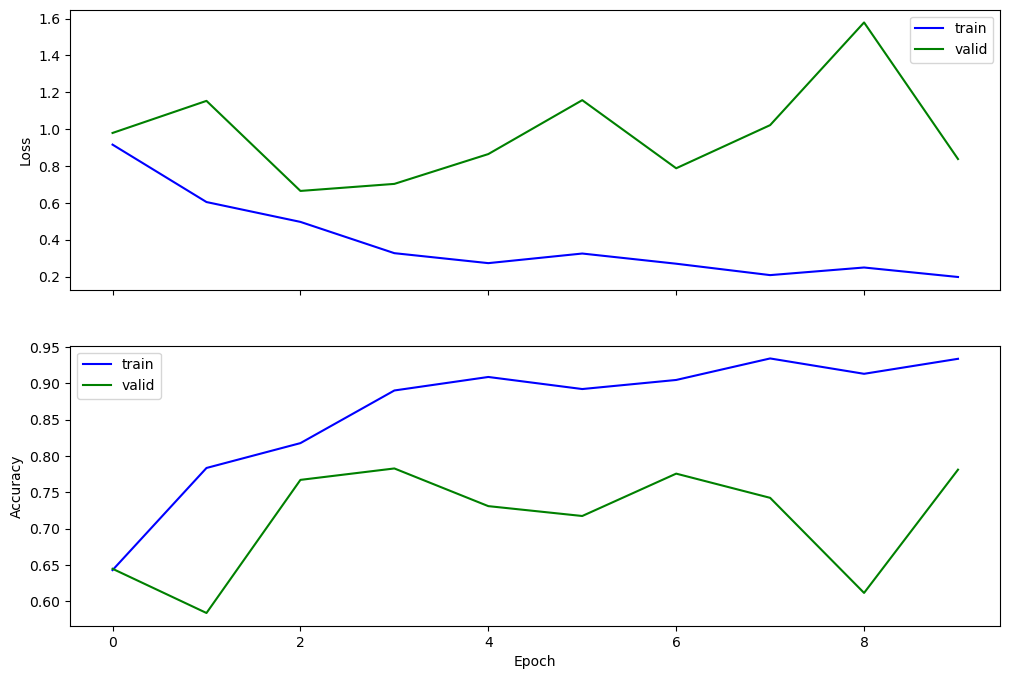

In [44]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 8), sharex=True)
ax1.plot(train_losses, color='b', label='train')
ax1.plot(val_losses, color='g', label='valid')
ax1.set_ylabel("Loss")
ax1.legend()
ax2.plot(train_accs, color='b', label='train')
ax2.plot(val_accs, color='g', label='valid')
ax2.set_ylabel("Accuracy")
ax2.set_xlabel("Epoch")
ax2.legend()

Final evaluation on the test set

In [45]:
test_accuracy, test_loss = 0, 0
with torch.no_grad():
    # Iterate through batches
    for data, label in test_loader:
        # Move data to the used device
        data = data.to(device)
        label = label.to(device)
        # Forward pass
        test_output_i = model(data)
        test_loss_i = loss_fn(test_output_i, label)
        # Compute metrics
        acc = ((test_output_i.argmax(dim=1) == label).float().mean())
        test_accuracy += acc/len(test_loader)
        test_loss += test_loss_i/len(test_loader)

print("Test loss: {:.4f}".format(test_loss))
print("Test accuracy: {:.2f}%".format(test_accuracy*100))

Test loss: 0.8556
Test accuracy: 77.57%
